# Predicting the price of diamonds
## Phase 2: Statistical Modelling

#### Group Name: Group 23

#### Name(s) & ID(s) of Group Members: 
       
#### Jacob Hill s3870682
#### Thomas Monaghan s3541313
#### Thomas Yao s3832771

## Table of contents <a id="contents"></a>
- [Section 1.0 (Introduction)](#1.0)
    - [1.1 (Phase 1 Summary)](#1.1) 
    - [1.2 (Report Overview)](#1.2) 
    - [1.3 (Overview of Methodology)](#1.3) 
- [Section 2.0 (Statistical Modelling)](#2.0) 
    - [2.1 (Model Overview)](#2.1) 
    - [2.2 (Model Fitting)](#2.2) 
    - [2.3 (Neural Network Model Fitting & Tuning)](#2.3) 
- [Section 3.0 (Critique & Limitations)](#3.0) 
- [Section 4.0 (Summary & Conclusions)](#4.0) 
    - [4.1 (Project Summary)](#4.1) 
    - [4.2 (Summary of Findings)](#4.2) 
    - [4.3 (Conclusions)](#4.3) 

# 1.0 Introduction <a id='1.0'></a>

## 1.1 Phase 1 Summary <a id='1.1'></a>

In phase 1 we introduced our dataset 'Diamonds' and our intention for using this dataset to predict the price of diamonds based on their physical attributes.

To achieve an accurate model for predicting a diamond's price, our initial task included cleaning & preprocessing the data. This involved checking for incorrect & missing values, looking at the amount of unique values, and checking the datatypes of each variable. We found records which included extreme values for the variables y and z, as well as records which included a measure of 0 for x, y and z. We removed these values as the likelihood they were meaningful values was very low.

We then began investigating the distribution of certain variables, plotting their value distribution, and their values against price.

We observed that the carat variable was multimodal, with large groupings around multiples of 1 and then observable peaks again at multiples of .1. In our literature review we explored an idea of 'magic numbers' which might explain this, the theory is that jewellers would be aiming for round numbers when working with diamonds.

We discovered in exploring the variable table, that it seemingly had little to no influence on price, as for almost any record of table, you could find many records outside of the upper and lower quartiles. When investigating depth we found a similar graph when plotted against price.

One of the most helpful graphs for us was a scatterplot of carat against price, where each record is colored by clarity. This helped to indicate that carat had a much larger effect on price than clarity.

In our literature review, we discussed the conditions of the market that influence the price of the diamonds. In particular we discussed the way in which e-commerce has the effect of changing the demand of diamonds into that of a commodity, rather than their current luxury item status. Another discussion involved the 'magic numbers' discussed earlier.

The conclusion of our phase 1 report included reasonings that drive our interest in predicting diamond prices, a summary of our data processing & cleaning, as well as our findings from variable exploration.

Return to [Table of contents](#contents)
___

## 1.2 Report Overview <a id='1.2'></a>

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

In our phase 2 report, we will use python libraries to enable us to map a linear regression model to our dataset of diamond price and physical attributes, with the intention of creating a model that will accurately predict the price of a diamond based on it's physical attributes. This will involve tuning the model, possibly using feature selection and further refinement of the dataset, to increase the accuracy of our predictions. We will employ methods of investigating the residuals of our predictions against the actual observed prices to see if a linear regression model is appropriate for this dataset. We will also employ software which will allow us to leverage neural networks in modelling this linear regression. 

We will discuss the results of this investigation, with critiques of our model's performance, as well as any limitations we encountered. 

The report will end with a summary, discussing the tasks we performed across both this and our earlier report. We will present our findings and conclusions in regards to our intention of predicting diamond prices based on physical attributes.

Return to [Table of contents](#contents)
___

## 1.3 Overview of Methodology <a id='1.3'></a>

A detailed, complete, and accurate overview of your statistical modelling methodology.

We will be using our "clean" data set from our phase 1 report to try to create a regression model that accurately predicts the price of diamonds based on other known characteristics of diamonds. 

The process of our statistical modelling will be:
1. checking the data set is ready model fitting
2. creating regression formula to be used in the statsmodels package
3. dummy encoding our categorical features for use in the model
4. fitting our data to the ordinary least squares regression model
5. reviewing the regression model results
6. checking for indications of violations the the regression assumptions
7. backward feature selection to attempt to create a better fitting model

Return to [Table of contents](#contents)
___

# 2.0 Statistical Modelling <a id='2.0'></a>

## 2.1 Model Overview <a id='2.1'></a>

Below is the formula of the price estimate.

$$\widehat{price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 $$

$\beta_0 $ is the y intercept

$\beta_1 x_1 $ is the 

### Variables

Our model will be created using six numeric variables - carat, depth, table, x, y, z - and three categorical variables - cut, color, clarity.

Our variables in the model are described in the table below.

| Variable Name | Data Type | Units | Brief description |
|:---|:---|:---|:---|
|**carat** | Numeric | 200 mg | Weight of the diamond
|**cut** | Ordinal Categorical | NA | The quality of the cut (shape) of the diamond
|**color** | Ordinal Categorical | NA | The Coloration of the diamond, the less colour the better. In ascending order, the categories are as follows (J, I, H, G, F, E, D)
|**clarity** | Ordinal Categorical | NA | Measurement of clarity in the diamond. In ascending order, the categories are as follows (I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF)
|**x** | Continuous Numerical | mm | Measured length of the diamond
|**y** | Continuous Numerical | mm | Measured width of the diamond
|**z** | Continuous Numerical | mm | Measured height of the diamond
|**depth** | Continuous Numerical | NA | Proportion of the depth divided by the average of the x and y values
|**table** | Continuous Numerical | NA | Width of the top of the diamond, proportionate to the widest point

Our dependent variable we will be trying to predict is the `price` of the diamond.

### Interaction terms 

We will explore interaction terms to see if there is a stronger relationship between carat and the "best" values from the categorical features of cut, color and clarity.

### Model

The terms we use in this report include:
- <b> $R^{2}$ </b>: This is the measure of variance around the fitted values of regression. 
- <b> Adjusted $R^{2}$ </b>: This is a similar measure of variance, however the value changes dependent on the size of observations in a model. The intention of this adjusted value is to observe if we are overfitting the model.
- <b> Overfitting </b>: This is when a model is needlessly complex, which can end up going against the intention of a model used to predict values that exist outside of the dataset.
-<b> P-value </b>: In terms of linear regression, the p-value is the probability that the coefficient considered has zero effect for predicting the target variable.
-<b> Multicollinearity </b>: This describes a scenario where there is a high degree of correlation between some of the variables in a regression model.
-<b> Interaction Terms </b>: This is when one of our predictor variables has a different effect on the estimate, depending on the value of another predictor variable. One interaction we were keen on studying was the interaction between carat and the different qualities such as clarity, color and cut.
Key metrics from our model include the **adjusted R-squared** for the overall model and the **P values** for each variable.


A low <b> P-value </b> indicates the coefficient is not 0 for the given variable, at a given significances level. We will use 0.05 to indicate if the variable is significant when the the P value is below this level.
A high P-value (above 0.05) would indicate a non significant variable and would potentially be dropped in the process of backward selection.

$$ R^2 = 1 - \frac{SS_\text{residuals}}{SS_\text{total}} $$



$$ R^2_\text{adj} = 1 - (\frac{SS_\text{residuals}}{SS_\text{total}} \times \frac{(n-1)}{(n-k-1)}) $$


Return to [Table of contents](#contents)
___

## 2.2 Model Fitting <a id='2.2'></a>

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

#### Module Imports

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy.stats import probplot

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

data = pd.read_csv('clean_diamond_df.csv')

In [144]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


In [145]:
data.describe()

,carat,depth,table,x,y,z,price
count,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000
mean,0.797687,61.749565,57.456939,5.731605,5.733428,3.539409,3930.910474
std,0.473777,1.432318,2.234069,1.119402,1.111272,0.691620,3987.215003
min,0.200000,43.000000,43.000000,3.730000,3.680000,1.070000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,949.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,2401.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5323.000000
max,5.010000,79.000000,95.000000,10.740000,10.540000,6.980000,18823.000000


In [146]:
data.describe(include='object')

,cut,color,clarity
count,53917,53917,53917
unique,5,7,8
top,Ideal,G,SI1
freq,21547,11284,13063


### Categorical Features

Let's have a look at the unique values of the categorical columns.

In [147]:
categoricalColumns = data.columns[data.dtypes==object].tolist()

for col in categoricalColumns:
    print('Unique values for ' + col)
    print(data[col].unique())
    print('')

Unique values for cut
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']

Unique values for color
['E' 'I' 'J' 'H' 'F' 'G' 'D']

Unique values for clarity
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']



We will need to remove the whitespace for 'Very Good' in cut for the statsmodels to function properly.

In [148]:
data.loc[data['cut'] == 'Very Good', 'cut'] = 'Very_Good'

In [149]:
data['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very_Good', 'Fair'], dtype=object)

We can now see the the whitespace is removed.

By chance, the worst values for **cut** (Fair) and **clarity** (I1) are ordered first lexicographically, this means they will be made the base level and dropped during dummy encoding. To keep this consistent and displaying a positive coefficient if possible, we will also adjust the **color 'J'** to be the first value lexicographically to make it the base level for color.

In [150]:
data['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [151]:
data.loc[data['color'] == 'J', 'color'] = 'AJ'

In [152]:
data['color'].unique()

array(['E', 'I', 'AJ', 'H', 'F', 'G', 'D'], dtype=object)

Now we have 'J' renamed to 'AJ' - this will not impact the model, but will make it the base level for color.

Finally, lets check that the variable types area correct. Float for numeric and object for categorical.

In [153]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

### Full Model
We begin by fitting a multiple linear regression that predicts the price of diamonds using all of the avaliable features. We call this the full model. First let's take a quick peak at the clean data.

In [154]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,AJ,SI2,63.3,58.0,4.34,4.35,2.75,335


When constructing the regression formula, we can manually add all the independent features. On the other hand, if there are lots of independent variables, we can get smart and use some string function tricks as below.

In [155]:
formula_string_indep_vars = ' + '.join(data.drop(columns='price').columns)
formula_string = 'price ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  price ~ carat + cut + color + clarity + depth + table + x + y + z


The formula string above works just fine with the Statsmodels module. The problem, however, is that we cannot do automatic variable selection with this formula. What we need for this purpose is "one-hot-encoding" of categorical features. For more information on this encoding, please refer to this page.

In the code chunk below, we first use the get_dummies() function in Pandas for one-hot-encoding of categorical features and then we construct a new formula string with the encoded features.

In [156]:
# one-hot-encoding of categorical features
# for this to work correctly, variable data types (numeric or categorical)
# must be correctly specified within the Pandas dataframe
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_D,color_E,color_F,color_G,color_H,color_I,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,326,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,326,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,327,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,334,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,335,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [157]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='price').columns)
formula_string_encoded = 'price ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_D + color_E + color_F + color_G + color_H + color_I + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


Let's add three interaction terms to our limited range model. Let's see what results we get from the interaction of carat with what is considered the "best" value from cut, color and clarity.

In [158]:
formula_string_encoded = formula_string_encoded + ' + carat:cut_Ideal + carat:color_D + carat:clarity_IF '

Now that we have defined our statistical model formula as a Python string, we fit an OLS (ordinary least squares) model to our encoded data.

In [160]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 2.511e+04
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:38:55   Log-Likelihood:            -4.5320e+05
No. Observations:               53917   AIC:                         9.065e+05
Df Residuals:                   53889   BIC:                         9.067e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -4635.9662    632.771  

The full model has an adjusted R-squared value of 0.921, which means that 92% of the variance is explained by the model. By looking at the p-values, we observe that all of them are highly significant.

Due to such a low P value backward feature selection on this model would not change any results.

Let's define a new data frame for actual price vs. predicted price and the residuals for the full model. We will use this data frame when plotting predicted values and the regression residuals.

In [161]:
residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.sample(10, random_state=999)

,actual,predicted,residual
32064,781,732.925821,48.074179
16425,6563,6584.350553,-21.350553
31316,759,355.283041,403.716959
17416,6982,6807.703241,174.296759
33033,814,1158.244852,-344.244852
22546,10602,10600.524153,1.475847
45067,1646,2118.234380,-472.234380
17216,6887,7383.220536,-496.220536
34624,872,806.016623,65.983377
372,2808,3248.999168,-440.999168


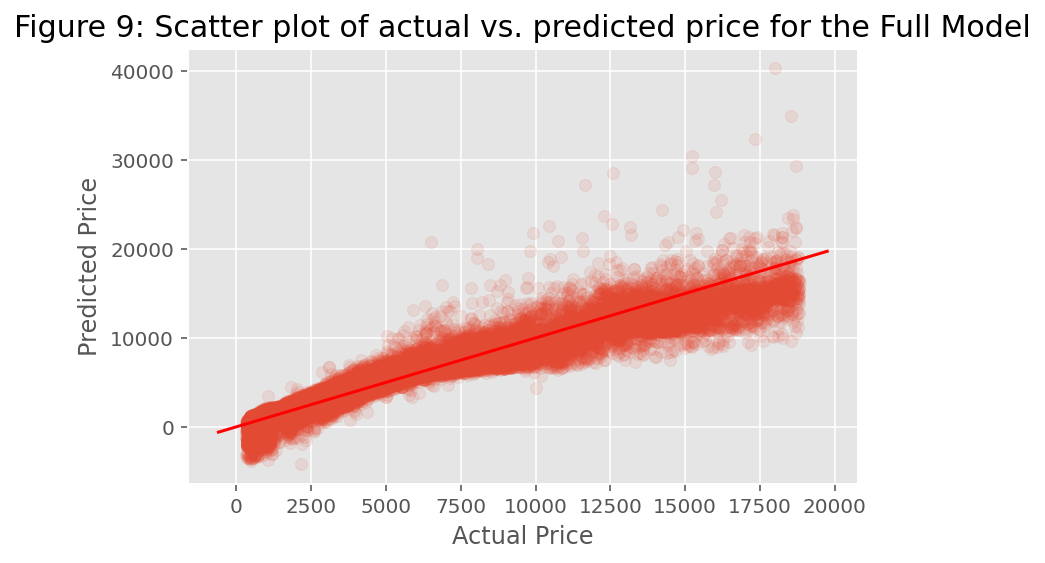

In [162]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.1);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

### Full Model Diagnostic Checks
We would like to check whether there are indications of violations of the regression assumptions, which are

1. linearity of the relationship between target variable and the independent variables
2. constant variance of the errors
3. normality of the residual distribution
4. statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted age).

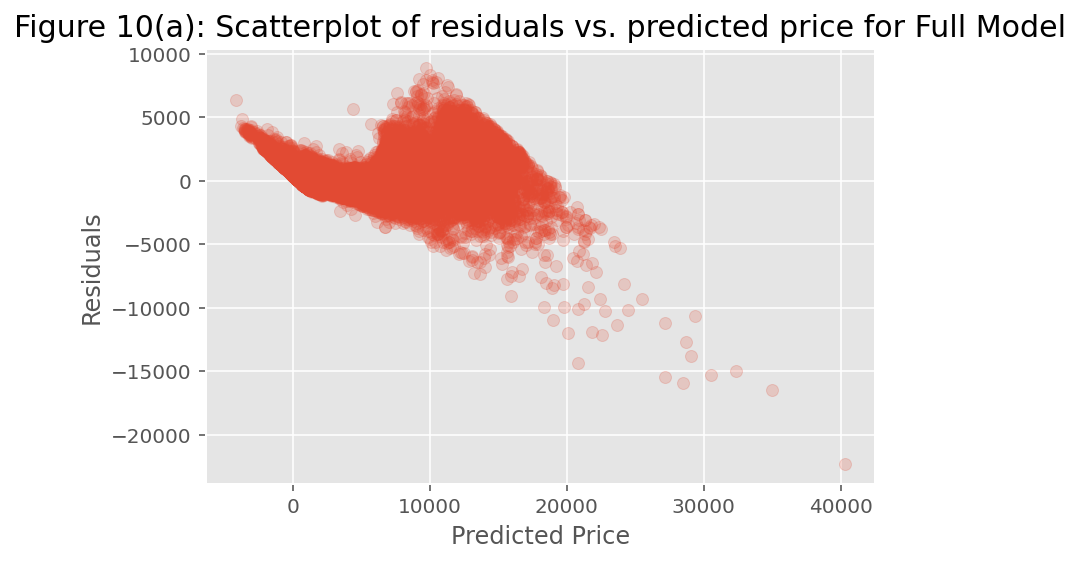

In [163]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.2);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Scatterplot of residuals vs. predicted price for Full Model', fontsize=15)
plt.show();

This plot is showing a strong skew of the data. The model seems to be under predicting on values above $15,000 by an extreme margin, showing extreme outliers.

Let's now plot actual price vs. residuals.

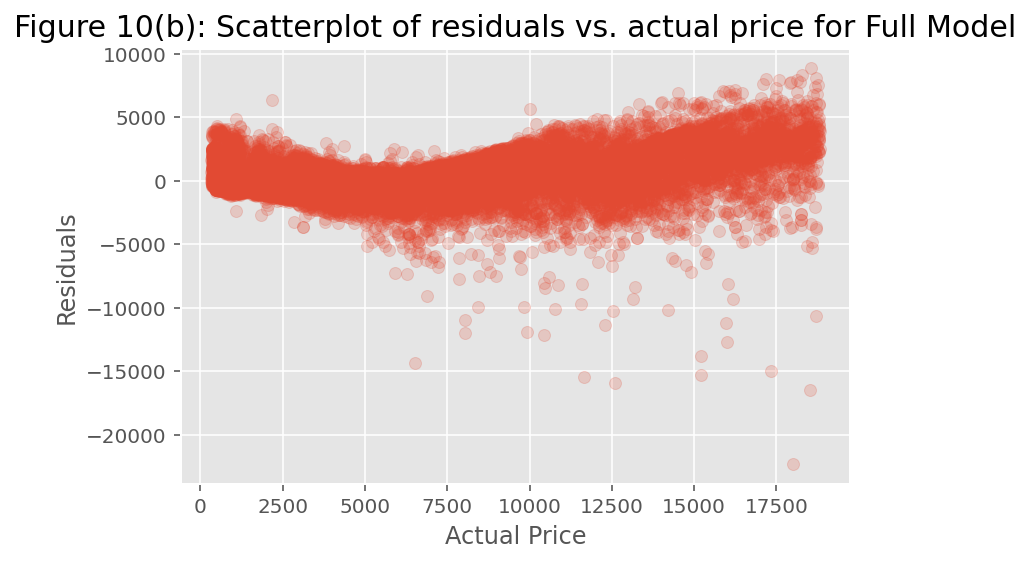

In [164]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.2);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

There is a distinct curve and widening in range of the residuals to the upper end of actual price. This would indicate the linearity and constant variance constraints are violated.

This may suggest that transformation of our data is required or that a linear regression model may not be a suitable fit.

Let's overlay the histograms of actual vs. predicted price on the same plot.

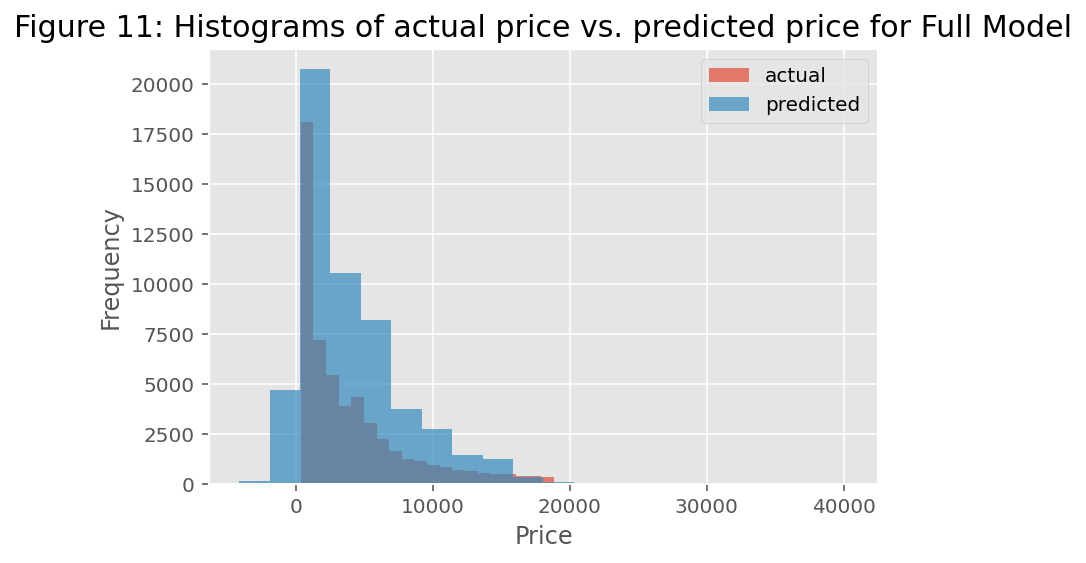

In [165]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Price');
plt.ylabel('Frequency');
plt.title('Histograms of actual price vs. predicted price for Full Model', fontsize=15);
plt.legend()
plt.show();

Let's now have look at the histogram of the residuals.

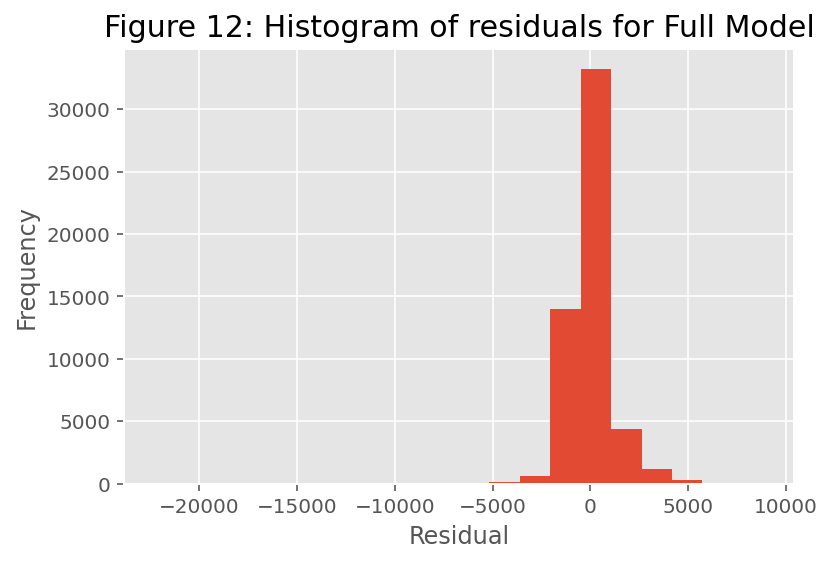

In [166]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Histogram of residuals for Full Model', fontsize=15);
plt.show();

In [167]:
residualsLog = np.log(residuals_full['residual'])

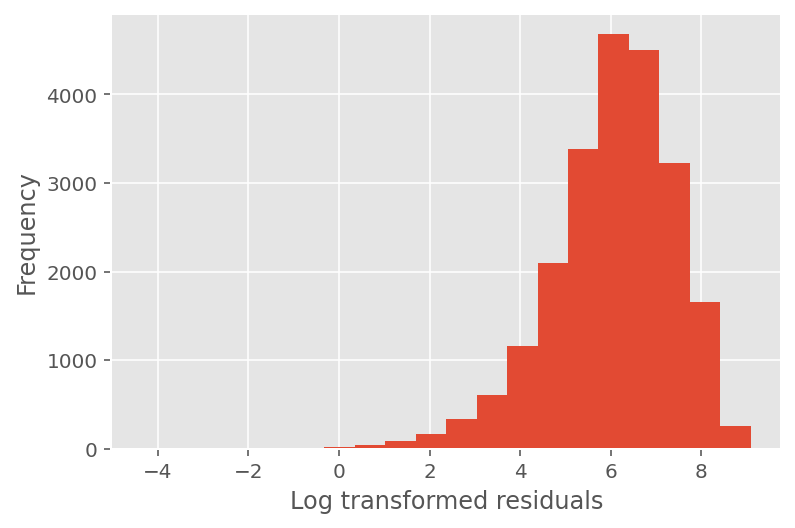

In [168]:
plt.hist(residualsLog, bins = 20);
plt.xlabel('Log transformed residuals');
plt.ylabel('Frequency');
plt.show();

As we can see more clearly by the log transformation on the residuals, there is a left skew present that would indicate the normality assumption of linear regression might be violated here.

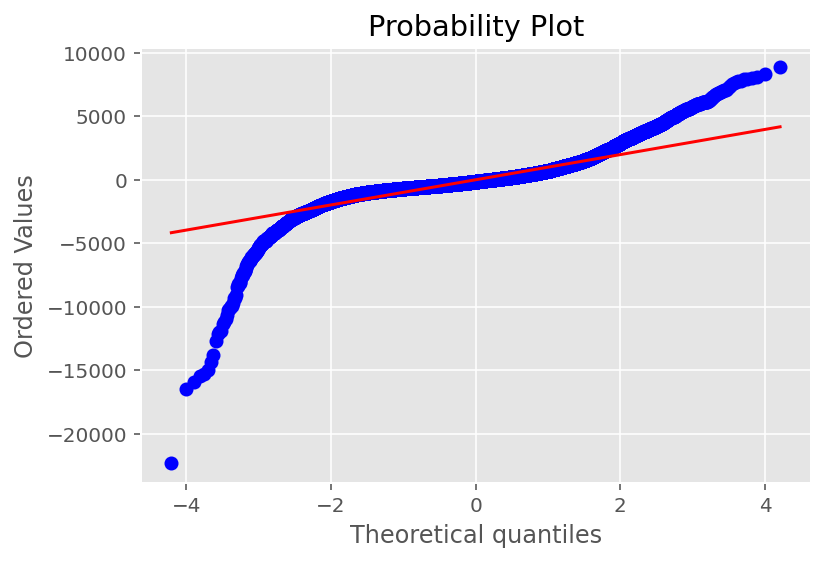

In [169]:
probplot(residuals_full['residual'], plot = plt)
plt.show(); 

Finally, this probability plot shows the residuals are not normally distributed at the upper and lower bounds. 

It appears from our diagnostic check plots, a model fitted with data from a certain range of price could be a better predictor?
We will try to test with price > \\$2000 and price < \\$7000 in the **Model fitting limited range of price data** section to see how our results compare.

### Model fitting with 1% sample
When we plot the predicted price vs actual price of the entire dataset on a scatterplot below, we observe a distribution that appears to show an association with an $R^2$ value much lower than 0.9. This may be due to the limitations of a scatterplot in rendering over 50,000 values.

We will visualise the predicted values from a 1% sample dataset. This will assist in clearer visualisation of the residuals.

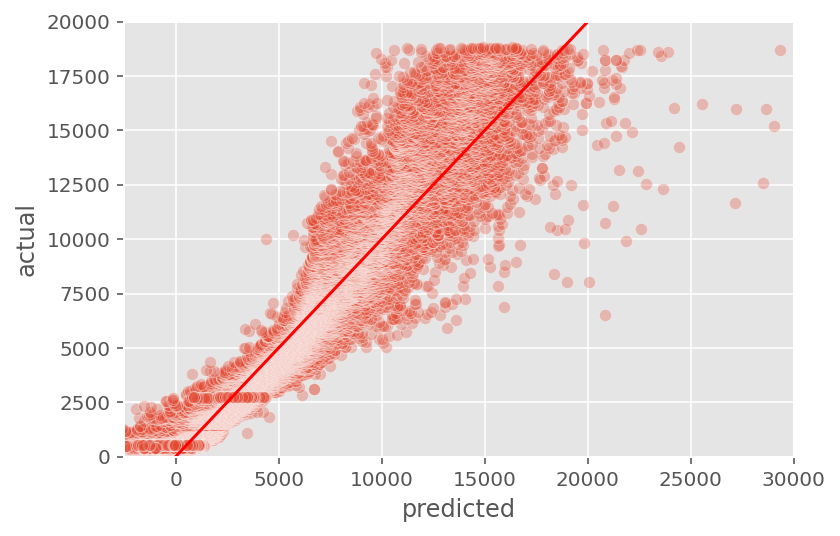

In [170]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

sns.scatterplot(x=residuals_full['predicted'], y=residuals_full['actual'], alpha=0.3)
plt.xlim(-2500, 30000)
plt.ylim(0, 20000)
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.show()

In [171]:
# resetting formula string encoded to remove interaction terms
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='price').columns)
formula_string_encoded = 'price ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_D + color_E + color_F + color_G + color_H + color_I + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


In [172]:
sample = data_encoded.sample(frac=0.01, random_state=90)
sample.shape

(539, 24)

In [173]:
model_sample = sm.formula.ols(formula=formula_string_encoded, data=sample)
###
model_sample_fitted = model_sample.fit()
###
print(model_sample_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     311.4
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          7.22e-285
Time:                        00:38:58   Log-Likelihood:                -4528.5
No. Observations:                 539   AIC:                             9105.
Df Residuals:                     515   BIC:                             9208.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.648e+04   1.17e+04     -2.262

In [174]:
sample_residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_sample_fitted.fittedvalues, 
                            'residual': model_sample_fitted.resid})

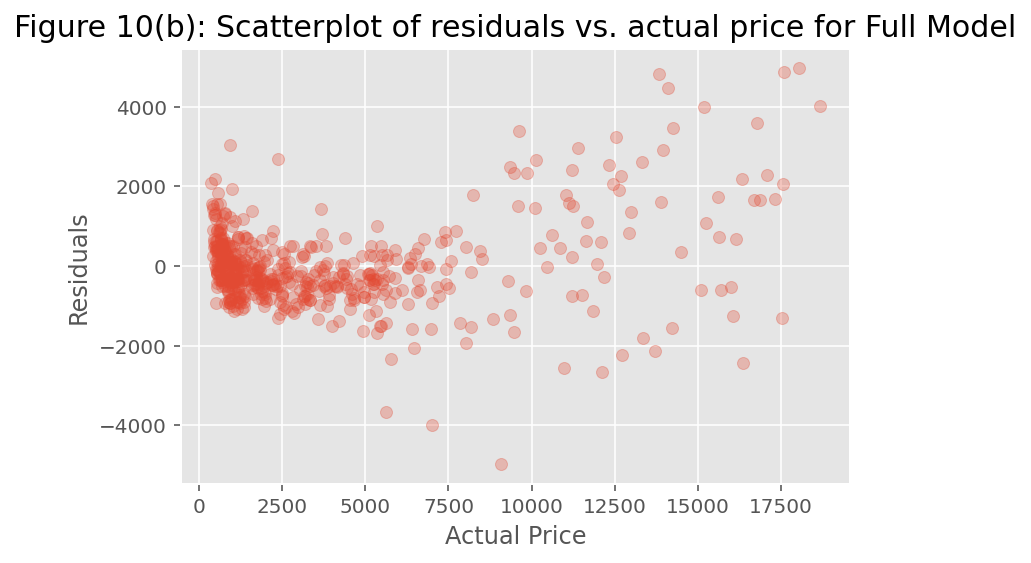

In [175]:
plt.scatter(sample_residuals_full['actual'], sample_residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Scatterplot of residuals vs. actual price for 1% Sample Model', fontsize=15)
plt.show();

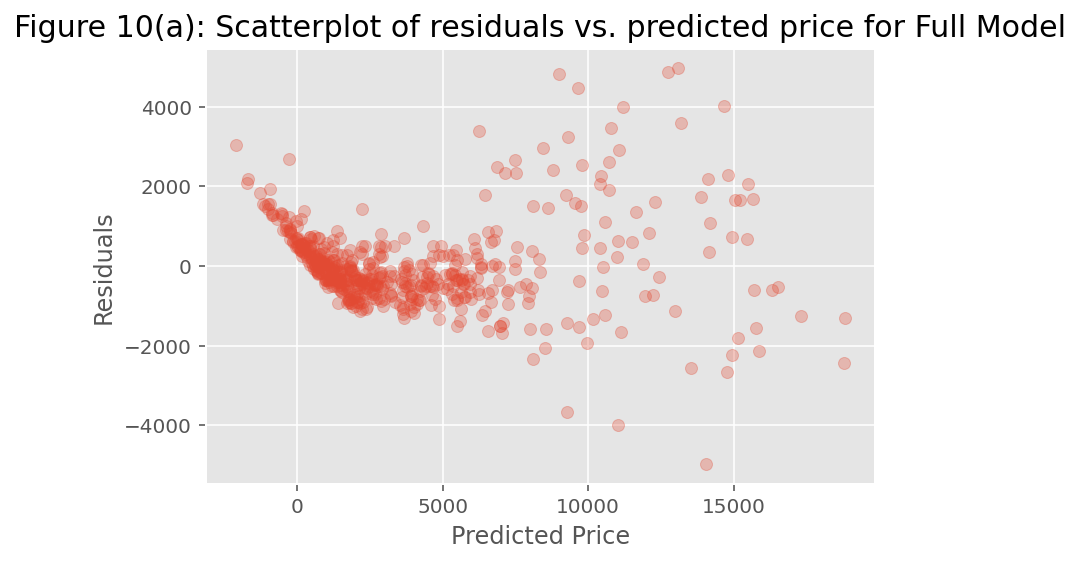

In [176]:
plt.scatter(sample_residuals_full['predicted'], sample_residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted price for 1% Sample Model', fontsize=15)
plt.show();

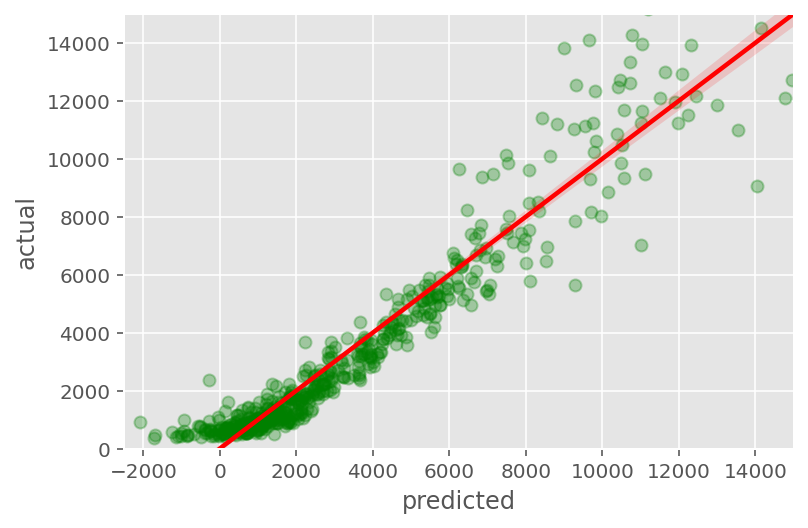

In [177]:
sns.regplot(x=sample_residuals_full['predicted'], y=sample_residuals_full['actual'], scatter_kws={"color": "g", 'alpha':0.3}, line_kws={"color": "red"})
plt.xlim(-2500, 15000)
plt.ylim(0, 15000)
plt.show()

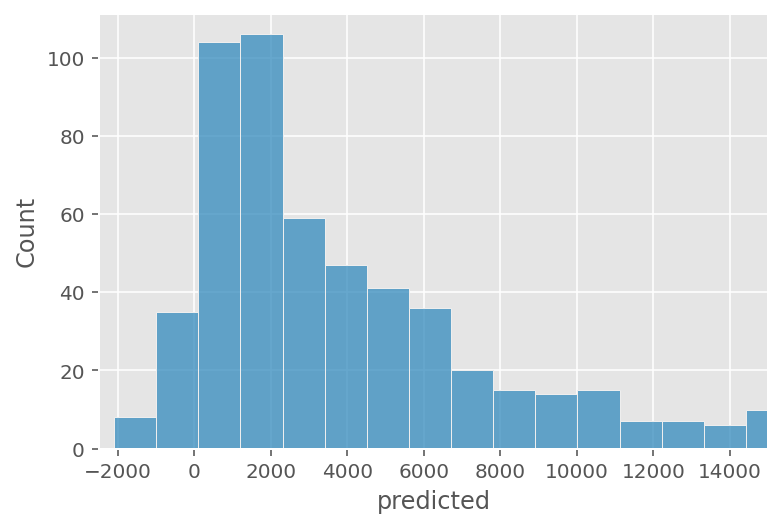

In [178]:
sns.histplot(x=sample_residuals_full['predicted'])
plt.xlim(-2500, 15000)
plt.show()

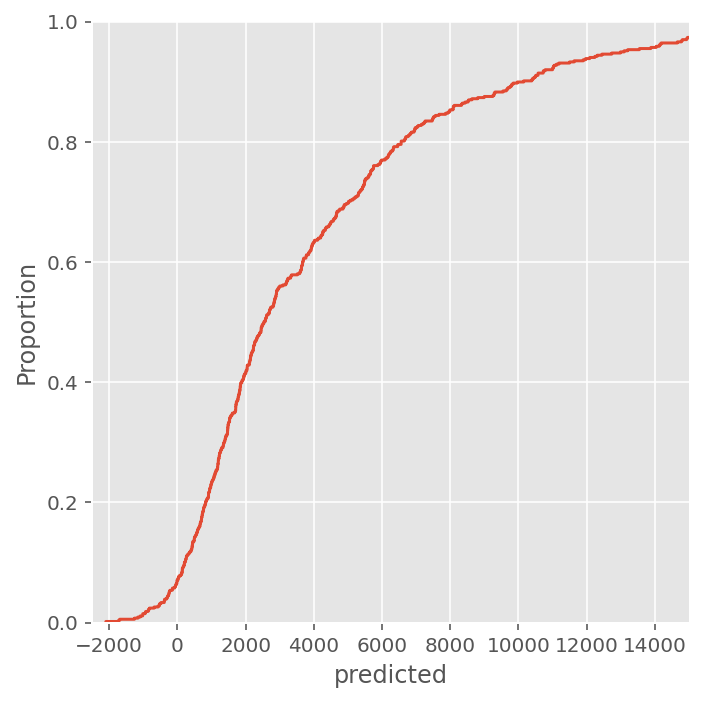

In [179]:
sns.displot(x=sample_residuals_full['predicted'], kind="ecdf")
plt.xlim(-2500, 15000)
plt.show()

Taking 1% of the dataset (500 values from 50000), we can better observe the density/distribution of predicted vs actual values. For the majority of the values (between 0 and 2000$ in predicted value), the predicted value is very close to the actual value. The R-Squared value of ~0.92 can be visually observed.
* Using seaborn's regplot function, the line of best fit is almost exactly what we expect it to be - an exact 1-to-1 relationship between predicted and actual price.
* As predicted/actual price increase, the variability increases as well (breaking the constant variability assumption)
* However, only <20\% amount of the data exist in this region (based on the empirical cumulative distribution function graph)

From this we can see that scatterplots of the full dataset are misleading, due to it's size (50000+ values), we cannot comparitively observe the densities of points.

We could potentially limit the maximum price of diamonds in our model to around $8000, where we start to observe inconsistent variability.

Additionally, the curved pattern observed in the residual plots can also be seen in the actual vs predicted graph. Based on the ECDF graph, about 5% of the values result in a negative predicted price, which causes the bending on the left of the residual plots. 
* Setting a minimum price for our data may also help remove this non-linearity

Lastly, from the OLS regression results of our 1% sample, we can see that some variables have a P value >0.05, so we can perform backwards feature selection to see if that would improve the performance of our model.

#### Backwards feature selection on 1% sample

In [180]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_sample_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=sample).fit()
    
###
## this is the clean fit after backwards elimination
model_sample_reduced_fitted = smf.ols(formula = patsy_description, data = sample).fit()
###
    
#########
print("\n***")
print(model_sample_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_sample_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_sample_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_sample_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_sample_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "x" with p-value 0.8514

Removing term "table" with p-value 0.5476

Removing term "cut_Good" with p-value 0.07485

Removing term "cut_Very_Good" with p-value 0.09248

Removing term "cut_Premium" with p-value 0.06618

***
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     393.8
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          3.67e-289
Time:                        00:38:59   Log-Likelihood:                -4533.6
No. Observations:                 539   AIC:                             9105.
Df Residuals:                     520   BIC:                             9187.
Df Model:                          18                                       

Although the $R^2$ value has slightly decreased, it is interesting to see that X, table, and the cut grades have been removed. This is in line with our phase 1 analysis, where X almost had a 1 to 1 relationship with Y (meaning using either alone in our model would be sufficient), and almost no association could be observed in the table variable. 

The cut grades also appeared to play a minimal role in determining the price of a diamond, although very minor patterns could be observed, which may explain why the $R^2$ value decreased slightly with its removal here.

### Model fitting limited range of price data  \\$2000 - \\$7000

In [181]:
data_range = data[(data['price'] > 2000) & (data['price'] < 7000)]
data_range.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
90,0.70,Ideal,E,SI1,62.5,57.0,5.70,5.72,3.57,2757
91,0.86,Fair,E,SI2,55.1,69.0,6.45,6.33,3.52,2757
92,0.70,Ideal,G,VS2,61.6,56.0,5.70,5.67,3.50,2757
93,0.71,Very_Good,E,VS2,62.4,57.0,5.68,5.73,3.56,2759
94,0.78,Very_Good,G,SI2,63.8,56.0,5.81,5.85,3.72,2759


In [182]:
data_range.describe()

,carat,depth,table,x,y,z,price
count,20445.000000,20445.000000,20445.000000,20445.000000,20445.000000,20445.000000,20445.000000
mean,0.924657,61.819614,57.796366,6.202862,6.201361,3.833808,4050.907606
std,0.216932,1.617272,2.291182,0.486457,0.477058,0.307135,1374.887180
min,0.300000,43.000000,43.000000,4.330000,4.110000,1.070000,2001.000000
25%,0.720000,61.000000,56.000000,5.790000,5.800000,3.570000,2815.000000
50%,0.930000,61.900000,58.000000,6.250000,6.240000,3.870000,3973.000000
75%,1.040000,62.700000,59.000000,6.540000,6.530000,4.040000,5082.000000
max,3.000000,79.000000,79.000000,9.230000,9.100000,5.770000,6999.000000


Constructing the regression formula for the limited range of values model.

In [183]:
formula_string_indep_vars_range = ' + '.join(data_range.drop(columns='price').columns)
formula_string_range = 'price ~ ' + formula_string_indep_vars_range
print('formula_string: ', formula_string_range)

formula_string:  price ~ carat + cut + color + clarity + depth + table + x + y + z


The formula string above works just fine with the Statsmodels module. The problem, however, is that we cannot do automatic variable selection with this formula. What we need for this purpose is "one-hot-encoding" of categorical features. For more information on this encoding, please refer to this page.

In the code chunk below, we first use the get_dummies() function in Pandas for one-hot-encoding of categorical features and then we construct a new formula string with the encoded features.

In [184]:
# one-hot-encoding of categorical features
# for this to work correctly, variable data types (numeric or categorical)
# must be correctly specified within the Pandas dataframe
data_encoded_range = pd.get_dummies(data_range, drop_first=True)
data_encoded_range.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_D,color_E,color_F,color_G,color_H,color_I,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
90,0.70,62.5,57.0,5.70,5.72,3.57,2757,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
91,0.86,55.1,69.0,6.45,6.33,3.52,2757,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
92,0.70,61.6,56.0,5.70,5.67,3.50,2757,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
93,0.71,62.4,57.0,5.68,5.73,3.56,2759,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
94,0.78,63.8,56.0,5.81,5.85,3.72,2759,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [185]:
formula_string_indep_vars_encoded_range = ' + '.join(data_encoded_range.drop(columns='price').columns)
formula_string_encoded_range = 'price ~ ' + formula_string_indep_vars_encoded_range
print('formula_string_encoded: ', formula_string_encoded_range)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_D + color_E + color_F + color_G + color_H + color_I + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


Let's add three interaction terms to our limited range model.

In [186]:
formula_string_encoded_range = formula_string_encoded_range + ' + carat:cut_Ideal + carat:color_D + carat:clarity_IF '

**Also, let's add the square of the hours_per_week feature to illustrate how we can add higher order terms to our linear regression.**

In [187]:
# formula_string_encoded = formula_string_encoded + ' + np.power(hours_per_week, 2)'
# print('formula_string_encoded: ', formula_string_encoded)

Now that we have defined our statistical model formula as a Python string, we fit an OLS (ordinary least squares) model to our encoded data.

In [188]:
model_range = sm.formula.ols(formula=formula_string_encoded_range, data=data_encoded_range)
###
model_range_fitted = model_range.fit()
###
print(model_range_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     5863.
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:38:59   Log-Likelihood:            -1.5601e+05
No. Observations:               20445   AIC:                         3.121e+05
Df Residuals:                   20421   BIC:                         3.123e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.525e+04    570.481    -44.266

The limited range model has an adjusted R-squared value of 0.869, which means that almost 87% of the variance is explained by the model. By looking at the p-values, we observe that all of them are still significant, due to a p value of almost 0.

Due to such a low P value backward feature selection on this model would not change any results.

Let's define a new data frame for actual price vs. predicted price and the residuals for the full model. We will use this data frame when plotting predicted values and the regression residuals.

In [189]:
residuals_range = pd.DataFrame({'actual': data_encoded_range['price'], 
                            'predicted': model_range_fitted.fittedvalues, 
                            'residual': model_range_fitted.resid})
residuals_range.sample(10, random_state=999)

,actual,predicted,residual
16657,6662,5904.767741,757.232259
51544,2390,1667.300033,722.699967
5632,3879,3605.506780,273.493220
15960,6391,4889.765750,1501.234250
15234,6121,5739.917530,381.082470
49017,2055,1570.531310,484.468690
9108,4531,4609.101831,-78.101831
15605,6262,5719.045699,542.954301
14979,6037,5425.248852,611.751148
8339,4398,4689.175637,-291.175637


In [1]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_range['actual'], residuals_range['predicted'], alpha=0.2);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the limited range Model', fontsize=15);
plt.show();

NameError: name 'plt' is not defined

#### Feature Selection

Due to the low p-values, backward feature selection would not remove any features from our model.

### Transformations
We will individually transform variables to test if we can increase the R-squared value of our model. From Phase 1, we observed that X, Y, Z variables had very clear non-linear associations with price, following a squared or cubic pattern.

Similar non-linearity can be observed in the residual plots as well.

In order to attempt to linearise this, we will apply an x squared and x cubed transformation to the X variable, and test if this improves the performance of our model.

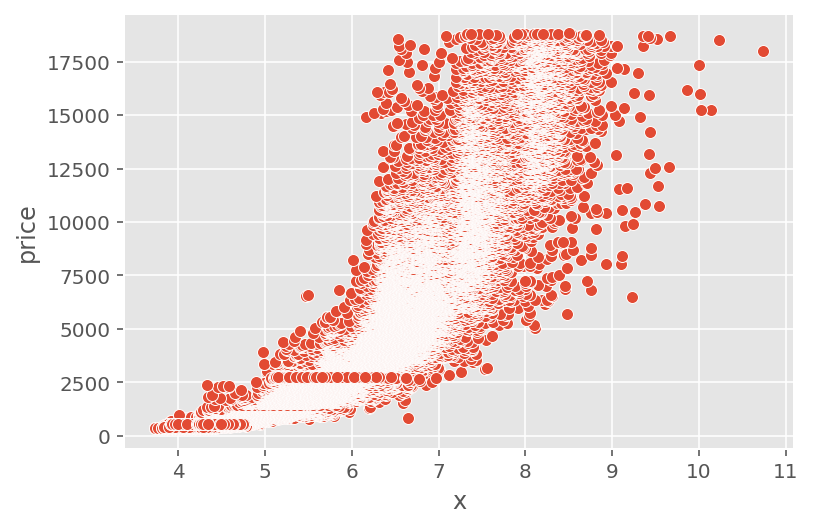

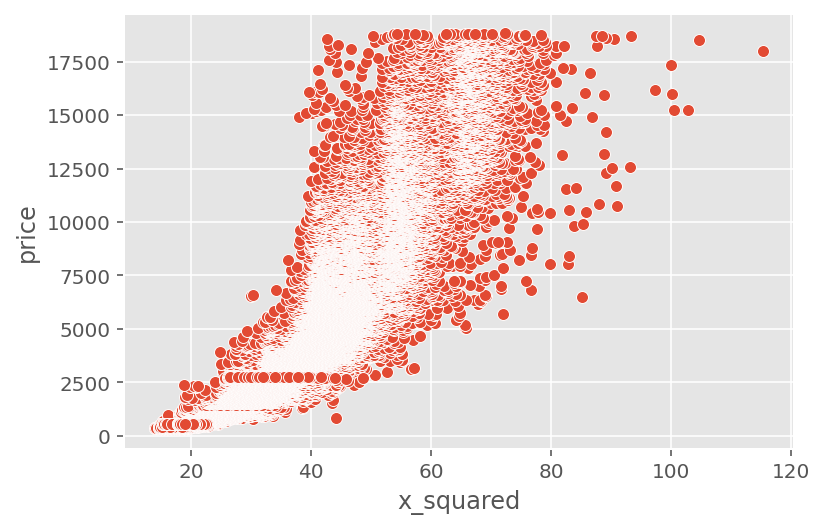

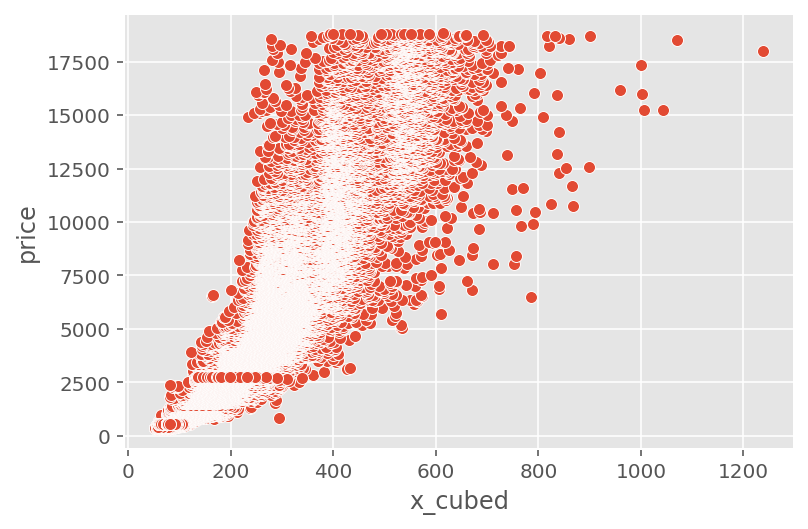

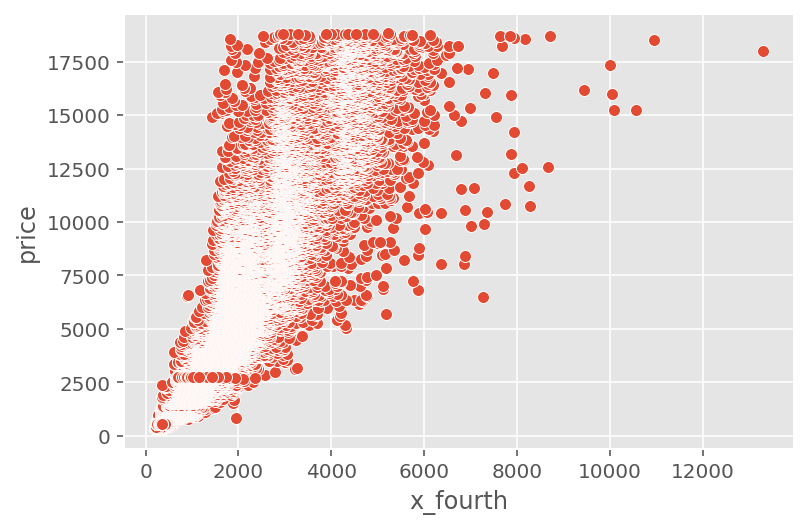

In [192]:
sns.scatterplot(x="x", y="price", data=data_encoded)
plt.show()

data_encoded["x_squared"] = data_encoded["x"] ** 2
sns.scatterplot(x="x_squared", y="price", data=data_encoded)
plt.show()

data_encoded["x_cubed"] = data_encoded["x"] ** 3
sns.scatterplot(x="x_cubed", y="price", data=data_encoded)
plt.show()

data_encoded["x_fourth"] = data_encoded["x"] ** 4
sns.scatterplot(x="x_fourth", y="price", data=data_encoded)
plt.show()

In [193]:
test_string_encoded = 'price ~ x'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X produces R-Squared value of: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ x_squared'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^2 produces R-Squared value of: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ x_cubed'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^3 produces R-Squared value of: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ x_fourth'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ X^4 produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ X produces R-Squared value of:  0.7871614773999794
OLS model for Price ~ X^2 produces R-Squared value of:  0.8274480050613038
OLS model for Price ~ X^3 produces R-Squared value of:  0.850171465606506
OLS model for Price ~ X^4 produces R-Squared value of:  0.8525233927426286


We can see the R-squared value approach a value of ~0.85 as we increase the power of the x transformation. X^4 appears to yield the highest R-squared value.


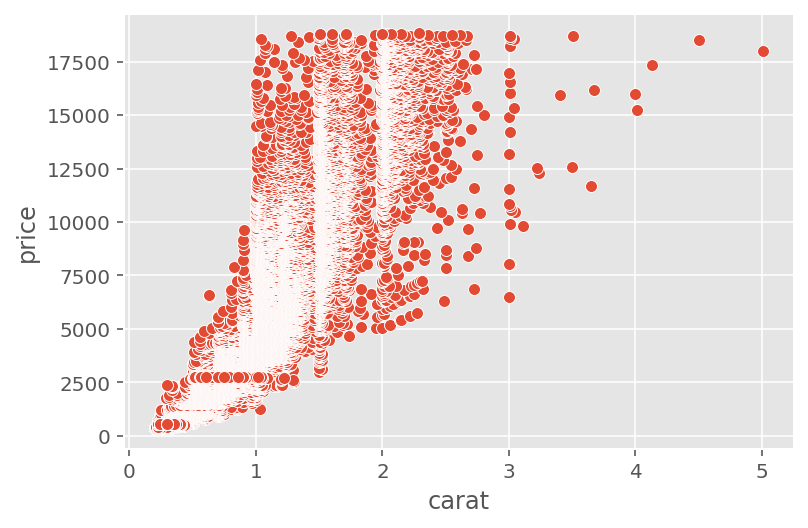

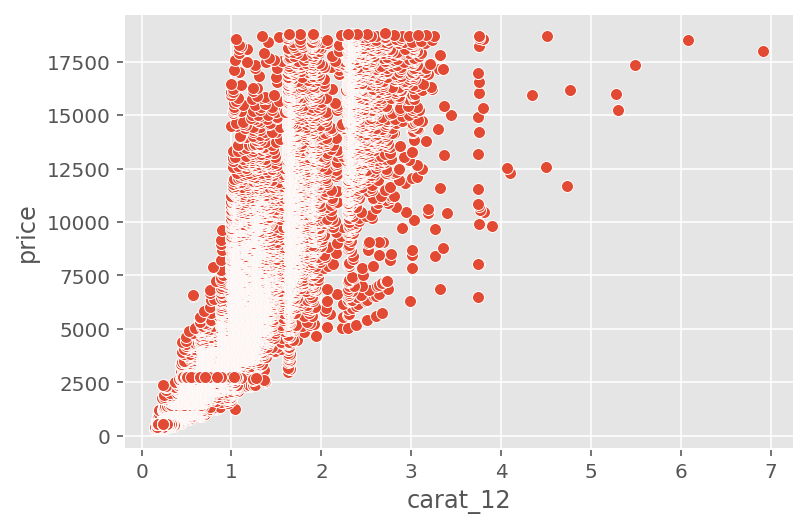

In [194]:
sns.scatterplot(x="carat", y="price", data=data_encoded)
plt.show()

data_encoded["carat_12"] = data_encoded["carat"] ** 1.2
sns.scatterplot(x="carat_12", y="price", data=data_encoded)
plt.show()

In [195]:
test_string_encoded = 'price ~ carat'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ Carat produces R-Squared value of: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ carat_12'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("OLS model for Price ~ Carat ^ 1.2 produces R-Squared value of: ", model_full_fitted.rsquared)

OLS model for Price ~ Carat produces R-Squared value of:  0.8493201274671618
OLS model for Price ~ Carat ^ 1.2 produces R-Squared value of:  0.8533857937003274


Price ~ Carat reaches a max R-Squared when we transform Carat ^ 1.2. The increased benefits are very marginal and would make interpretation of the carat variable difficult and tedious. It is probably not worth it to apply this transformation.

**Based on phase 1, carat can be quite predictably calculated based on cuboidal volume (x*y*z), this may mean that transforming the 3 dimensional variables and dropping carat may yield a stronger model.**

#### Applying transformations to the entire model

We will now apply the X^4 transformation along with other variables to observe its effect on the predictive strength of our model.

In [197]:
test_string_encoded = 'price ~ x + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_D + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x and all CATEGORICAL variables: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ x_fourth + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_D + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x^4 and all CATEGORICAL variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x and all CATEGORICAL variables:  0.8437568668937631
R-Squared of price ~ x^4 and all CATEGORICAL variables:  0.9108991555022052


* When we test the R-squared value of price ~ x + all other **categorical** variables, we get an R-Squared value of **0.843756**

* When we test the R-squared value of price ~ x^4 + all other **categorical** variables, we get an R-Squared value of **0.9109**

As the only numerical variable in the model, transforming x increases the strength of the model

In [199]:
test_string_encoded = 'price ~ x + carat + y + z + depth + table + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_D + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x and ALL other variables: ", model_full_fitted.rsquared)

test_string_encoded = 'price ~ x_fourth + carat + y + z + depth + table + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_D + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'
model_full = sm.formula.ols(formula=test_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print("R-Squared of price ~ x^4 and ALL other variables: ", model_full_fitted.rsquared)

R-Squared of price ~ x and ALL other variables:  0.9205774447870843
R-Squared of price ~ x^4 and ALL other variables:  0.920275117192205


When we test the R-squared value of price ~ x + all other **categorical + numerical** variables, we get an R-Squared value of **0.9206**

However, when we test the R-squared value of price ~ x^4 + all other **categorical + numerical** variables, we get an R-Squared value of **0.9203**

* When we mix x^4 with other original numerical variables, the predictive strength of the model is decreased.
* This suggests that x may need to be transformed in conjunction with the other variables as it worsens the performance when included with other untransformed numerical variables.

Return to [Table of contents](#contents)
___

## 2.3 Neural Network Model Fitting & Tuning <a id='2.3'></a>

Advanced Submission Mode Only

NOTE: Here is a link that Vural has provided to assist us https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-7-neural-networks-simple-case-study/

Return to [Table of contents](#contents)
___

# 3.0 Critique & Limitations <a id='3.0'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

In our full model the condition number given to us by the statsmodels Ordinary Least Squares fit summary is large, at 13,400. This could be as all our data are to the right of price = 0, causing a high sensitivity around the y intercept. We can observe strange modelling in this area where the model suggests negative prices for diamonds with certain physical attributes, however a negative price is not possible for this object. Seeing as we are not interested in our model giving an accurate y intercept, as a price of zero is not possible, this is not of great concern.

When plotting actual price against predicted price with the full model and full dataset we see a slight bend. This led us to investigate whether linear regression was appropriate, or fails to accurately describe the data. Whilst the curve is visible, the intense density of records near the models prediction gives us an adjusted $R^{2}$ of .922 which indicates that any change in our models predictor variables will explain 92.2% of the change in our target variable.

Another concern of ours was the accuracy of our prediction as the price increases. When plotting actual price against predicted price we see variability increasing as the price exceeds \\$7000, we have created a model, using a dataset with only those records under \\$7000 and above \\$xxx TODO. In this range our model's residuals are far more linear, with a more consistent variability. We must consider which model provides more use to us, the original will provide a less accurate model for diamonds of any price, whereas the latter model is only intended for diamonds within a certain price range. Diamonds have a large variability in price in the real world, with prices reaching millions of dollars, however at this upper bound there are many influences on the price which may not be explained by physical characteristics, or at least, not in a linear fashion. The model with a limited bound of price would provide incredible accuracy at (TODO INSERT R^2 VALUE OF LIMITED MODEL HERE) for diamonds of a price from (TODO LOWER BOUND) - \\$7000. This accuracy and a range of several thousands of dollars will provide use to everyone involved in the diamond market.

Return to [Table of contents](#contents)
___

# 4.0 Summary & Conclusions <a id='4.0'></a>

## 4.1 Project Summary <a id='4.1'></a>

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

Return to [Table of contents](#contents)
___

## 4.2 Summary of Finding <a id='4.2'></a>

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

Return to [Table of contents](#contents)
___

## 4.3 Conclusions <a id='4.3'></a>

Your detailed conclusions as they relate to your goals and objectives.

As demonstrated in this report, we have achieved our intention of creating a model that can accurately predict diamond prices based on physical attributes. In the case of our neural network model, we achieved an adjusted $R^{2}$ value of 0.98. In our own research we have found that an adjusted $R^{2}$  value above .85 is very strong, which demonstrates to us that our model seems to excel in accuracy. We can conclude that depending on the accuracy of this dataset in representing the relationship between physical characteristics and price of diamonds in the real world, our model can provide an accurate prediction for a diamonds price based on it's physical attributes.

Return to [Table of contents](#contents)
___